***Created on 2021-04-14 22:48:45***

Title: "胶质瘤肿瘤细胞边界识别"  
Date: "2021-04-14"  
Tips : 本次使用的数据集是来自TCGA-LGG的数据，代码参考[kaggle](https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn)  
Best Regards,  
Yuan.SH

Please contact with me via following way:  
(a) E-mail :yuansh3354@163.com  
(b) QQ :1044532817  
(c) WeChat :YuanSh18101  

***@author: yuansh***

本次的流程主要包括以下三个部分：

1. 数据预处理

2. 模型准备

3. 模型训练

### 基础包的导入 

In [1]:
%%capture
import os
import math
import itertools
import warnings
import numpy as np
import glob 
import pandas as pd
from collections import Counter
import multiprocessing
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%matplotlib inline
warnings.filterwarnings("ignore")
pl.utilities.seed.seed_everything(seed=42)


### 定义全局变量

`DATA_PATH`:数据存放路径,这个目录下面存放每一个样本文件夹，每个样本文件夹下面存放的是对应的 **image** 和 **mask** 

>树结构
.  
├── 1.txt  
└── kaggle_3m  
    ├── data.csv   
    ├── README.md  
    ├── **TCGA_CS_4941_19960909**  
    │   ├── TCGA_CS_4941_19960909_10_mask.tif  
    │   ├── TCGA_CS_4941_19960909_10.tif  
    │   ├── TCGA_CS_4941_19960909_11_mask.tif  
    │   ├── TCGA_CS_4941_19960909_11.tif  
    │   ├── TCGA_CS_4941_19960909_12_mask.tif  
    │   ├── TCGA_CS_4941_19960909_12.tif  

`BASE_LEN`:基本字符长度。所有的样本都有固定的ID编码格式，其中 **TCGA_CS_4941_19960909_** 为样本编码ID长度为22，加上相对路径长度，基本字符累积长度为86

`END_IMG_LEN`：image的后缀 **.tiff**，累积长度4

`END_MASK_LEN`：mask后缀 **_mask.tif**，累积长度9

`IMG_SIZE`：初始化image大小

In [2]:
# Path to all data
DATA_PATH = "../dataset/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 86
END_IMG_LEN = 4
END_MASK_LEN = 9

# img size
IMG_SIZE = 512

### 数据汇总表

同样注意，这个是数据预处理的第二个步骤。通常情况下我们拿到的应该是DICOM文件，然后需要对DICOM文件进行处理，转化为jpg文件或者其他特格式的图片，并且获取头文件信息。

然后，第二步就是将这些输出的图片的地址以及样本的信息进行汇总在一个excel表格方便后续操作。

In [3]:
# Raw data
data_map = []

# 遍历目录下的所有文件夹以及文件
for sub_dir_path in glob.glob(DATA_PATH+'*'):
    # 判断是否为文件夹
    if os.path.isdir(sub_dir_path):
        # 如果是文件夹，则获取样本ID
        dirname = sub_dir_path.split('/')[-1] # Get Sample ID 
        # 读取文件夹中的数据
        for filename in os.listdir(sub_dir_path):
            # 获取文件夹中的文件路径
            image_path = sub_dir_path + "/" + filename # Get imgs path
            # 将ID，以及文件家的图片对应并添加到list中：其中extend的作用类似于 ‘+‘ 
            data_map.extend([dirname, image_path])

# 将数据构建成DataFrame格式
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

,dirname,path
0,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...
1,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...
2,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...
3,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...
4,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...


##### 注意，这一部仅仅只是初步获取，还为对数据进行归纳 

In [4]:
# 将蒙板数据和MR数据分开存放
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# 和上述说的一样，注意到每一个样本的images的命名规则，尾巴有标注顺序，因此按尾巴的标注顺序进行排序
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# 检查图片和蒙板是否能够一一对应
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ../dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_25.tif 
Path to the Mask: ../dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_25_mask.tif


Final dataframe

In [5]:
# 因为图片和蒙板是一一对应的，所以构建一个矩阵其中第一列为样本ID，第二第三列为img和mask
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# 在增加一列信息用于存放是否有肿瘤
def positiv_negativ_diagnosis(mask_path):
    # 如果蒙板没有值，则蒙板全是黑色，mask全为0，否则蒙板有白色区域mask有不为0的值
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0
# 因此最后数据汇总表如下
df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df.to_csv('../out_file/data-infomation.csv')
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,0
1,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,0
2,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,0
3,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,0
4,TCGA_CS_5397_20010315,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,../dataset/lgg-mri-segmentation/kaggle_3m/TCGA...,0


### 检查数据总体分布情况

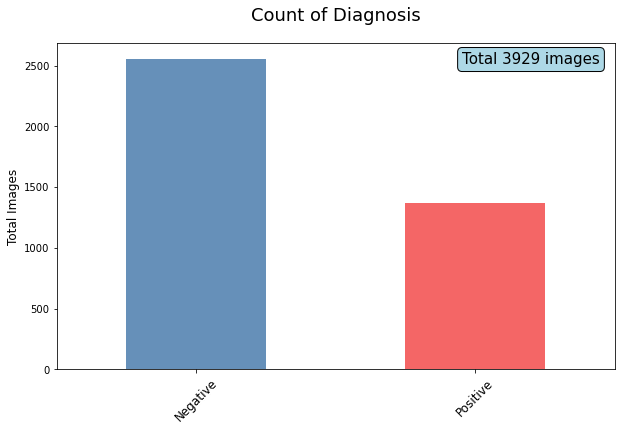

In [6]:
ax=df.diagnosis.value_counts().plot(kind='bar',
                                stacked=True,
                                figsize=(10,6),
                                color=[ "#00468B99","#ED000099" ])

ax.set_xticklabels(['Negative','Positive'],rotation=45, fontsize=12)
ax.set_ylabel('Total Images',fontsize=12)
ax.set_title('Count of Diagnosis',fontsize=18,y=1.05)
# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

### 检查样本总体分布情况

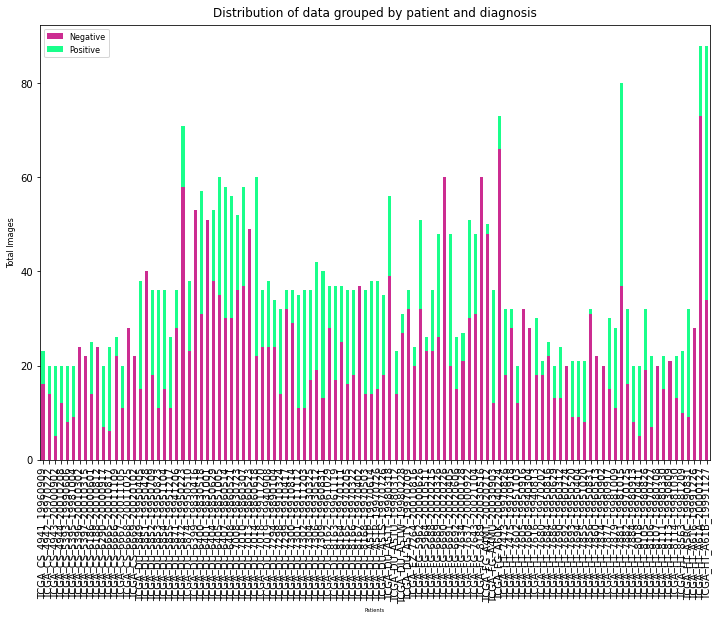

In [7]:
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ['Negative','Positive']
# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(12,8),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=8);
ax.set_xlabel('Patients',fontsize = 5)
ax.set_ylabel('Total Images', fontsize = 8)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 12, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

### 随机抽取几个样本进行可视化

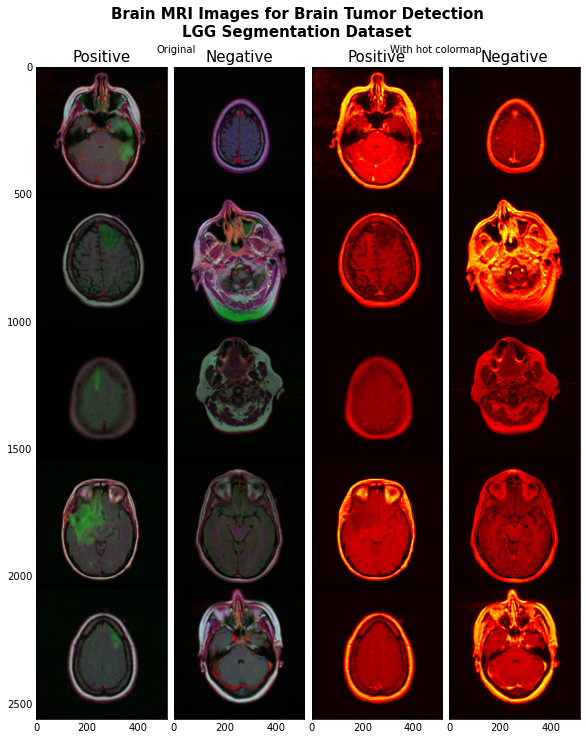

In [8]:
# 定义随机种子
pl.utilities.seed.seed_everything(seed=36)
sample_yes_df = df.loc[df['diagnosis'] == 1].sample(5).image_path.values # 随机抽取疾病组5个样本
sample_no_df = df.loc[df['diagnosis'] == 0].sample(5).image_path.values # 随机抽取对照组5个样本

sample_imgs = []
for i,(yes,no) in enumerate(zip(sample_yes_df,sample_no_df)):
    yes = cv2.resize(cv2.imread(yes),(IMG_SIZE,IMG_SIZE))
    no = cv2.resize(cv2.imread(no),(IMG_SIZE,IMG_SIZE))
    sample_imgs.extend([yes,no])
    
sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=10)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=10)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=15, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show();

### 查看图片与蒙板之间的对应关系

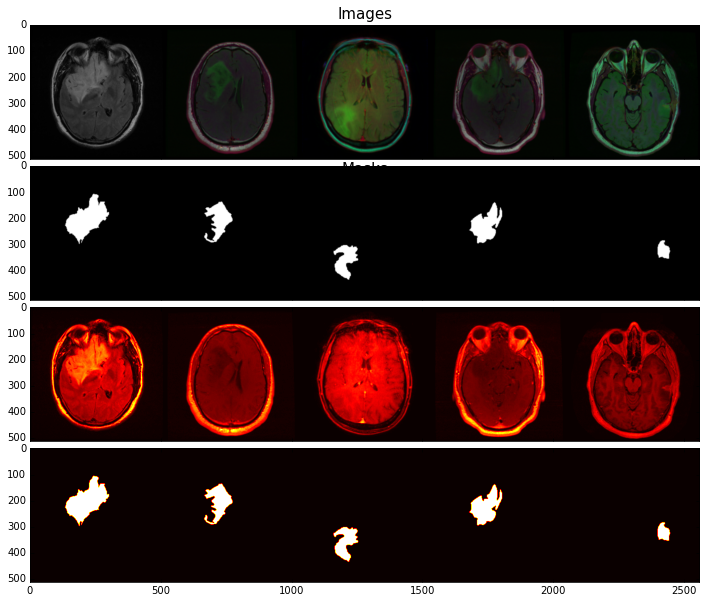

In [9]:
sample_df = df.loc[df['diagnosis'] ==1 ].sample(5).values
sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]),(IMG_SIZE,IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]),(IMG_SIZE,IMG_SIZE))
    sample_imgs.extend([img, mask])
    
sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))


# Data
pl.utilities.seed.seed_everything(seed=42)
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

grid[2].imshow(sample_imgs_arr[:,:,0], cmap="hot")
grid[2].axis("off")
grid[3].imshow(sample_masks_arr[:,:,0], cmap="hot")
grid[3].axis("off")#set_title("No", fontsize=15)


plt.show();

### 数据迭代器和数据增强


In [10]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask    
    
PATCH_SIZE = 128#256
transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensor(),
])

In [11]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [12]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

In [13]:
%%capture
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False);

### Model Zoo 

首先构建U-Net模型，其基本结构如下：
![img.png](https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=1241682492,2518903563&fm=26&gp=0.jpg)

### 关于 U-Net有两种上采样的方法
- `Upsample` 通过插值方法完成上采样。所以不需要训练参数，并且这个模型不会改变通道个数。

- `ConvTranspose2d` 可以理解为卷积的逆过程。所以可以训练参数

**由于医学图像的数本身的数据精度都比较复杂，因此考虑使用参数法构建U-Net**

__构建U-Net__

In [14]:
def Double_Conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(num_features=out_channels), nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(num_features=out_channels), nn.ReLU(inplace=True))


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_img_size=32):
        super().__init__()
        features = init_img_size
        # down
        self.conv_down1 = Double_Conv(3, features)
        self.conv_down2 = Double_Conv(features, features * 2)
        self.conv_down3 = Double_Conv(features * 2, features * 4)
        self.conv_down4 = Double_Conv(features * 4, features * 8)
        self.bottlent = Double_Conv(features * 8, features * 16)

        # max-pool
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # up
        self.conv_up1 = nn.Sequential(
            nn.ConvTranspose2d(features * 16,
                               features * 8,
                               kernel_size=2,
                               stride=2),
            nn.BatchNorm2d(num_features=features * 8), nn.ReLU(inplace=True))
        self.conv_up11 = Double_Conv(features * 16, features * 8)

        self.conv_up2 = nn.Sequential(
            nn.ConvTranspose2d(features * 8,
                               features * 4,
                               kernel_size=2,
                               stride=2),
            nn.BatchNorm2d(num_features=features * 4), nn.ReLU(inplace=True))

        self.conv_up21 = Double_Conv(features * 8, features * 4)

        self.conv_up3 =nn.Sequential(nn.ConvTranspose2d(features * 4,
                                           features * 2,
                                           kernel_size=2,
                                           stride=2),
            nn.BatchNorm2d(num_features=features * 2), nn.ReLU(inplace=True))
        
        self.conv_up31 = Double_Conv(features * 4, features * 2)

        self.conv_up4 = nn.Sequential(nn.ConvTranspose2d(features * 2,
                                           features,
                                           kernel_size=2,
                                           stride=2),
            nn.BatchNorm2d(num_features=features), nn.ReLU(inplace=True))
        
        self.conv_up41 = Double_Conv(features * 2, features)

        self.conv = nn.Conv2d(features, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.conv_down1(x)
        d2 = self.conv_down2(self.maxpool1(d1))
        d3 = self.conv_down3(self.maxpool2(d2))
        d4 = self.conv_down4(self.maxpool3(d3))

        bottlen = self.bottlent(self.maxpool4(d4))

        u1 = self.conv_up1(bottlen)
        u1 = self.conv_up11(torch.cat((u1, d4), dim=1))
        u2 = self.conv_up2(u1)
        u2 = self.conv_up21(torch.cat((u2, d3), dim=1))
        u3 = self.conv_up3(u2)
        u3 = self.conv_up31(torch.cat((u3, d2), dim=1))
        u4 = self.conv_up4(u3)
        u4 = self.conv_up41(torch.cat((u4, d1), dim=1))
        out = self.conv(u4)
        out = torch.sigmoid(out)
        return out


unet = UNet().to(device)
output = unet(torch.randn(1, 3, 256, 256).to(device))
print("", output.shape)

 torch.Size([1, 1, 256, 256])


### 语义分割的专用的评估指标

Dice 相似度：2*交集面积/两个区域的面积和

In [15]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    # 注意这个指标恒小于1
    # 当预测蒙板为0且实际没有蒙板的时候则准去率为100%
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union

# 定义dice loss
# 这个dice loss 主要是为了矫正并限定面积
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)

# bceloss主要是为了确定和矫正边界
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


In [16]:
class myNet(pl.LightningModule):
    train_epoch_loss = []
    train_epoch_acc = []
    val_epoch_loss = []
    val_epoch_acc = []
    test_predict = []
    test_sample_label = []
    test_sample = []
    
    def __init__(self, loss_fc=None,acc=None):
        super().__init__()
        self.myloss = loss_fc # 使用交叉商损失函数，最后输出无需激活
        self.acc = acc
        self.net = UNet()
        
    def forward(self, x):
        out = self.net(x)
        return out

    # 3. 定义优化器
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    # 4. 训练loop
    def training_step(self, train_batch, batch_ix):
        vector_sample, sample_label = train_batch
        probs = self.forward(vector_sample)
        loss  = self.myloss(probs, sample_label)
        acc = self.acc(probs, sample_label)
        mylogdict = {'loss': loss, 'log': {'train_loss': loss, 'train_acc': acc}}
        return mylogdict
    
    def validation_step(self, validation_batch, batch_ix):
        vector_sample, sample_label = validation_batch
        probs = self.forward(vector_sample)
        loss  = self.myloss(probs, sample_label)
        val_acc = self.acc(probs, sample_label)
        self.log_dict({'val_loss': loss, 'val_acc': val_acc})
        mylogdict = {'log': {'val_loss': loss, 'val_acc': val_acc}}
        return mylogdict
    
    def test_step(self, test_batch, batch_ix):
        vector_sample, sample_label = test_batch
        probs = self.forward(vector_sample)
        self.test_predict.append(probs.cpu())
        self.test_sample_label.append(sample_label.cpu())
        self.test_sample.append(vector_sample.cpu())
        return {'test': 0}
    
    def training_epoch_end(self, output):
        train_loss = sum([out['log']['train_loss'].item() for out in output]) / len(output)
        self.train_epoch_loss.append(train_loss)
        train_acc = sum([out['log']['train_acc'].item() for out in output]) / len(output)
        self.train_epoch_acc.append(train_acc)
        return train_loss
    
    def validation_epoch_end(self, output):
        val_loss = sum([out['log']['val_loss'].item() for out in output]) / len(output)
        self.val_epoch_loss.append(val_loss)
        val_acc = sum([out['log']['val_acc'].item() for out in output]) / len(output)
        self.val_epoch_acc.append(val_acc)
        if self.train_epoch_acc:
            print("训练集损失：",self.train_epoch_loss[-1],"\t","验证集损失：",val_loss)
            print("训练集准确率：",self.train_epoch_acc[-1],"\t","验证集准确率：",val_acc)
        return val_loss    

In [17]:
%%capture
loss_fc=dice_coef_loss
acc=dice_coef_metric
pl.utilities.seed.seed_everything(seed=42)
model = myNet(loss_fc,acc)

In [19]:
# Step.8 trainlinig Model
traning = False
pl.utilities.seed.seed_everything(seed=111)

if traning:
    # output file
    OUTPUT_DIR = './lightning_logs'
    tb_logger = pl.loggers.TensorBoardLogger(save_dir='./',
                                             name=f'check_point')
    # set check point to choose best model 
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=tb_logger.log_dir,
        filename='{epoch}-{val_acc:.5f}-{val_loss:.5f}',
        save_top_k = 50, #保留最优的15
        monitor='val_acc', # check acc 
        mode='max'
    )

    # train loop 
    trainer = pl.Trainer(gpus=-1, 
                         callbacks=[checkpoint_callback],
                         max_epochs = 100)# 开始训练
    trainer.fit(model, train_dataloader, val_dataloader)

    from pathlib import Path
    out = Path(tb_logger.log_dir)
    print(out)
    [ckpt.stem for ckpt in out.iterdir()]

111

In [20]:
# Select best Model
version = 'version_0' # choose best model path
path = os.path.join(os.getcwd(),'check_point',version)
ids = os.listdir(path)
best = np.argmax([float(i.split('-')[1].split('val_acc=')[1]) for i in ids])
ckpt = str(os.listdir(path)[best]) # choose best model 
# get best model parameter
ckpt = os.path.join(path,ckpt)
print(ckpt)

/media/yuansh/14THHD/glioma/code/check_point/version_0/epoch=93-val_acc=0.88795-val_loss=0.11203.ckpt


In [21]:
model = myNet()
model = model.load_from_checkpoint(ckpt)
trainer = pl.Trainer(gpus=-1)
def model_clf(model):
    model.train_epoch_loss = []
    model.train_epoch_acc = []
    model.val_epoch_loss = []
    model.val_epoch_acc = []
    model.test_predict = []
    model.test_sample_label = []
    model.test_sample = []
    return model

def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.show()

torch.Size([1, 1, 128, 128])


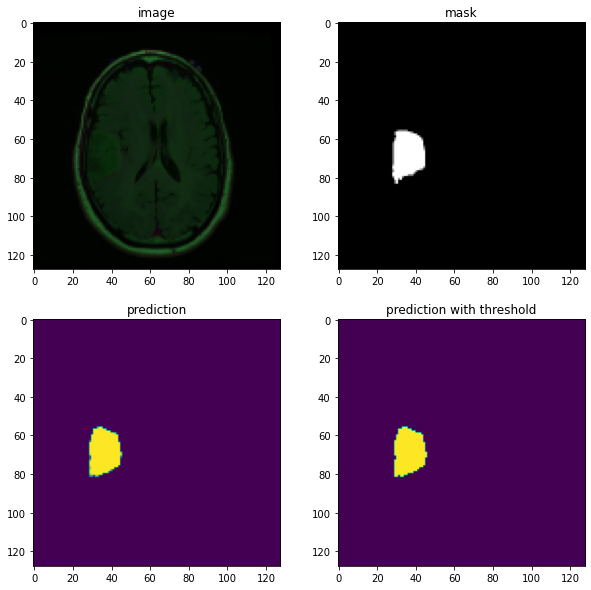

In [22]:
# image
test_sample = train_df[train_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = model(pred)
print(pred.shape)
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show();